In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint

In [2]:
entropy_list=[]
prob_list=[]

In [3]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [4]:
#train_df, test_df = train_test_split(df, test_size=20)

In [5]:
#train_df.head()
#test_df.head()

In [6]:

def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification


def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):        # excluding the last column which is the label
        potential_splits[column_index] = []
        values = data[:, column_index]
        unique_values = np.unique(values)

        for index in range(len(unique_values)):
            if index != 0:
                current_value = unique_values[index]
                previous_value = unique_values[index - 1]
                potential_split = (current_value + previous_value) / 2
                
                potential_splits[column_index].append(potential_split)
    
    return potential_splits

def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values >  split_value]
    
    return data_below, data_above



In [7]:
import pandas as pd
df=pd.read_csv('project/dataset/catalog1/cat1.csv')
#df.head()
#df.columns
df=df.drop(['Unnamed: 0', 'spectrometric_redshift','pred'],axis=1)
#df.head()
#df.head()
target=df['class']
target
df=df.drop(['class'],axis=1)


# def check_purity(data):
    
#     label_column = data[:, -1]
#     unique_classes = np.unique(label_column)

#     if len(unique_classes) == 1:
#         return True
#     else:
#         return False
    
# check_purity(df)

In [8]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    entropy_list.append(entropy)
    prob_list.append(probabilities[0])
    return entropy

def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [9]:

def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df           
    
#     data=df
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # instantiate sub-tree
        feature_name = COLUMN_HEADERS[split_column]
        question = "{} <= {}".format(feature_name, split_value)
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if example[feature_name] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [10]:

def calculate_accuracy(df, tree):

    df["pred_class"] = df.drop(["class"],axis=1).apply(classify_example, axis=1, args=(tree,))
    
    df["pred_class_correct"] = df["pred_class"] == df["class"]
    #print(df.head())
    accuracy = df["pred_class_correct"].mean()
    
    return accuracy

In [11]:
def calculate_metrics(df,tree):
        df["pred_class"] = df.drop(["class","spectrometric_redshift"],axis=1).apply(classify_example, axis=1, args=(tree,))
        TP=TN=FP=FN=0
        for i,j in list(zip(df["pred_class"], df["class"])):
            if i==j:
                if i==0:
                    TP+=1
                else:
                    TN+=1
            else:
                if i==0 and j==1:
                    FN+=1
                else:
                    FP+=1
          
        accuracy=(TP+TN)/(TP+TN+FP+FN)
        precision=TP/(TP+FP)
        recall=TP/(TP+FN)
        f1_score=(2*precision*recall)/(precision+recall)
        confusion_matrix=[[TP,FN],[FP,TN]]
        print("Confusion matrix")
        for i in confusion_matrix:
            print(i[0],"\t",i[1])
        print("\naccuracy: ",accuracy,"\n","precison: ",precision,"\n","recall: ",recall,"\n","f1_score: ",f1_score)
        
        return (confusion_matrix,accuracy,precision,recall,f1_score)
                

In [12]:
def upsample(df):
    c0 = 0
    c1 = 0
    for i in df['class']:
        if(i==0):
            c0+=1
        else:
            c1+=1


    #print(c0,c1)

    resample_size = c1

    # Shuffle the Dataset.
    shuffled_df = df.sample(frac=1,random_state=4)

    quaser = shuffled_df.loc[shuffled_df['class'] == 1]
    star = shuffled_df.loc[shuffled_df['class'] == 0].sample(n=resample_size,random_state=42, replace=True)

    # Concatenate both dataframes again
    normalized_df = pd.concat([star, quaser])

    return normalized_df



In [13]:
def validate_using_redshift(df):
    df["category"]=[1 if i < 0.033 else 2 if i>=0.04 else 3 for i in df["spectrometric_redshift"]]
    #print(df["category"])

In [14]:
def calculate_metrics_redshift(df,tree):
        df["pred_class"] = df.drop(["class"],axis=1).apply(classify_example, axis=1, args=(tree,))
        TP=TN=FP=FN=0
        for i,j in list(zip(df["pred_class"], df["category"])):
            if i==0 and j==1:
                TP+=1
            if i==0 and j==2:
                FN+=1
            if i==1 and j==2:
                TN+=1
            if i==1 and j==1:
                FP+=1
          
        accuracy=(TP+TN)/(TP+TN+FP+FN)
        precision=TP/(TP+FP)
        recall=TP/(TP+FN)
        f1_score=(2*precision*recall)/(precision+recall)
        confusion_matrix=[[TP,FN],[FP,TN]]
        print("Confusion matrix")
        for i in confusion_matrix:
            print(i[0],"\t",i[1])
        print("\naccuracy: ",accuracy,"\n","precison: ",precision,"\n","recall: ",recall,"\n","f1_score: ",f1_score)
        return (confusion_matrix,accuracy,precision,recall,f1_score)

In [15]:
df = pd.read_csv("catalog1/cat1.csv")

df=df.drop(['Unnamed: 0' ,'pred'],axis=1)

#target=df['class']
#target
#df=df.sample(8000)

#df=upsample(df)
#df.head()
#df.head()
target=df['class']
target

train_df, test_df = train_test_split(df, test_size=0.2)

#train_df=df.drop(['class'],axis=1)

train_df=upsample(train_df)
Y_train=train_df["class"]
train_df=train_df.drop(["class","spectrometric_redshift"],axis=1)

train_df["class"]=Y_train
#train_df=upsample(train_df)

#df.shape
#train_df.shape
#train_df.head()
tree = decision_tree_algorithm(train_df)
print(tree)


{'g-z <= -0.049106121063249505': [{'g-i <= 0.0194654464721505': [{'i <= 21.6188020706177': [{'i-z <= 0.13048839569089848': [0.0, 1.0]}, 1.0]}, 1.0]}, {'u-z <= 1.8087377548217498': [{'g-z <= 0.14268684387210048': [{'g-z <= 0.1320095062256': [1.0, {'r-z <= -0.0417690277099985': [1.0, 0.0]}]}, 1.0]}, {'fuv-g <= -3.81456279754635': [0.0, {'i-z <= 0.5147571563720985': [1.0, {'fuv-r <= -2.6122303009033': [1.0, 0.0]}]}]}]}]}


In [16]:
print("***********Results**************\n")
results=calculate_metrics(test_df,tree)
print("********************************\n")
print("********REDSHIFT_Results**********\n")
validate_using_redshift(test_df)
red_results=calculate_metrics_redshift(test_df,tree)
print("********************************\n")
#print("********results********",results)
#print("********RedshiftResults********",red_results)

***********Results**************

Confusion matrix
8 	 1
4 	 117

accuracy:  0.9615384615384616 
 precison:  0.6666666666666666 
 recall:  0.8888888888888888 
 f1_score:  0.761904761904762
********************************

********REDSHIFT_Results**********

Confusion matrix
8 	 1
4 	 117

accuracy:  0.9615384615384616 
 precison:  0.6666666666666666 
 recall:  0.8888888888888888 
 f1_score:  0.761904761904762
********************************



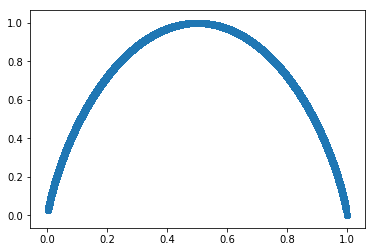

In [22]:
#print(entropy_list)
#print("---------------------------------------------------------")
#print(prob_list)
import matplotlib.pyplot as plt
plt.scatter(prob_list,entropy_list)
plt.xlabel="p"
plt.ylabel="entropy"
plt.show()

{'g-i <= -0.0949211120605505': [{'g-i <= -0.2842493057250995': [{'u-g <= -0.0170640945434': [{'fuv-z <= 0.0902385711670475': [1.0, 0.0]}, {'u-z <= 2.5110340118408': [0.0, 1.0]}]}, {'extinction_z <= 0.036912359297276': [{'z <= 20.470512390136697': [1.0, {'nuv-i <= 2.0945997238159046': [0.0, 1.0]}]}, {'nuv-i <= -0.6319169998169021': [1.0, {'u-i <= -0.2176904678344515': [1.0, 0.0]}]}]}]}, {'u-g <= 0.7502098083496485': [{'r-z <= 0.9076623916625483': [{'r <= 21.291113853454604': [1.0, {'g-r <= 0.11271953582764599': [0.0, 1.0]}]}, {'z <= 20.1913824081421': [{'i-z <= 0.4245929718018005': [1.0, 0.0]}, 1.0]}]}, {'u-g <= 0.9195671081542984': [{'z <= 20.825158119201653': [{'i <= 19.4840183258057': [0.0, 1.0]}, {'g-r <= 0.034213066101101': [0.0, 1.0]}]}, 0.0]}]}]}
***********Results**************

Confusion matrix
79 	 95
6 	 679

accuracy:  0.8824214202561118 
 precison:  0.9294117647058824 
 recall:  0.4540229885057471 
 f1_score:  0.61003861003861
********************************

********REDSH

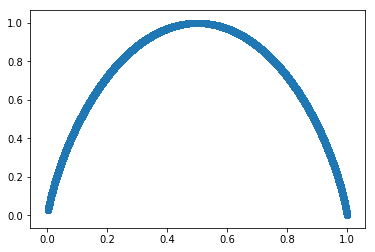

In [23]:
df = pd.read_csv("catalog3/cat3.csv")

df=df.drop(['Unnamed: 0' ,'pred'],axis=1)

#target=df['class']
#target
#df=df.sample(8000)

#df=upsample(df)
#df.head()
#df.head()
target=df['class']
target

train_df, test_df = train_test_split(df, test_size=0.2)

#train_df=df.drop(['class'],axis=1)

train_df=upsample(train_df)
Y_train=train_df["class"]
train_df=train_df.drop(["class","spectrometric_redshift"],axis=1)

train_df["class"]=Y_train
#train_df=upsample(train_df)

#df.shape
#train_df.shape
#train_df.head()
tree = decision_tree_algorithm(train_df)
print(tree)


print("***********Results**************\n")
results=calculate_metrics(test_df,tree)
print("********************************\n")
print("********REDSHIFT_Results**********\n")
validate_using_redshift(test_df)
red_results=calculate_metrics_redshift(test_df,tree)
print("********************************\n")
#print("********results********",results)
#print("********RedshiftResults********",red_results)

#print(entropy_list)
#print("---------------------------------------------------------")
#print(prob_list)
import matplotlib.pyplot as plt
plt.scatter(prob_list,entropy_list)
plt.xlabel="p"
plt.ylabel="entropy"
plt.show()